# Testing the number of events that best explains the data

We usually do not have precise enough information to decide a priori on a number of events that an HsM model should have. To illustrate the problem let's use the data from application 2 of this [this](https://link.springer.com/article/10.1007/s42113-021-00105-2) paper that we already prepared in section 1 of tutorial 1 and saved in ```sample_data/```. For the purpose of this tutorial we will only use the last four participants of the data (see [this](https://www.sciencedirect.com/science/article/pii/S1053811914002249) paper for the method and [https://osf.io/pd3kf/](https://osf.io/pd3kf/) for the whole (unpreprocessed) data)


In [2]:
import numpy as np
import xarray as xr
import hsmm_mvpy as hmp

cpus = 10

eeg_data = xr.load_dataset('sample_data/sample_data.nc')

#We create also the position array for the electrodes as we are going to need them to plot the event topologies
from mne import channels
montage = dict(channels.make_standard_montage('easycap-M1').get_positions())['ch_pos']#In this case electrodes are positioned according to the 10-20 system
positions = np.array([montage[x][:2] for x in eeg_data['electrodes'].values])#Extract x and y positions of each electrode

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Data preparation

First let's transform the data in principal component (PC) space

In [3]:
eeg_data

<xarray.Dataset>
Dimensions:      (epochs: 200, electrodes: 30, samples: 210, participant: 4)
Coordinates:
  * epochs       (epochs) int64 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
  * electrodes   (electrodes) object 'Fp1' 'Fp2' 'AFz' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 203 204 205 206 207 208 209
  * participant  (participant) object '0025' '0024' '0023' '0022'
Data variables:
    data         (participant, epochs, electrodes, samples) float64 2.891e+06...
    event        (participant, epochs) object 'SP/stim_right/resp_left' ... '...
Attributes:
    sfreq:    100
    offset:   0

When transforming the data, a prompt request us how many PC we want to keep. The best is to maximise the number of component kept so that we don't loose PC with useful information, but the more PC we include the more computationally intensive the estimations will be. For this two rules of thumb exists, taking PC that explain x% of the variance of the data or select the PC number at which the explained variance seems to almost stop decreasing (i.e. the "elbow" method)

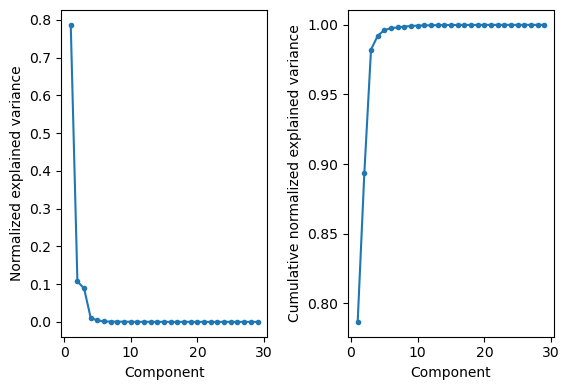

How many PCs (90 and 99% explained variance at component n3 and n4)? 5


In [4]:
hmp_data = hmp.utils.transform_data(eeg_data)

In this case we see that 99% is achieved with 4 PCs and this is globally coherent with when the explained variance really drops (with a larger number of electrodes than the 30 used here, 99% might be achieved with a lot more PC but the elbow might occur before that).

In [5]:
hmp_data

<xarray.DataArray (component: 5, all_samples: 52203)>
array([[-0.2046566 , -0.05111144, -0.08774414, ..., -0.50939348,
        -0.55622432, -0.40675313],
       [-0.61778236, -1.03023408, -0.36316206, ..., -0.34094971,
        -0.21139061, -0.37995304],
       [ 1.02769673,  1.5379683 ,  2.21930863, ...,  1.60175226,
         1.59015816,  1.01581133],
       [-0.4950929 ,  1.4196772 ,  0.25208962, ..., -1.39781108,
        -0.60134774, -0.07047409],
       [-1.86107248, -1.42898441,  1.50718557, ..., -0.76614202,
        -0.98781377, -0.54259851]])
Coordinates:
  * component    (component) int64 0 1 2 3 4
  * all_samples  (all_samples) object MultiIndex
  * participant  (all_samples) object '0022' '0022' '0022' ... '0025' '0025'
  * epochs       (all_samples) int64 0 0 0 0 0 0 0 ... 199 199 199 199 199 199
  * samples      (all_samples) int64 0 1 2 3 4 5 6 7 ... 95 96 97 98 99 100 101

And we initialize the model

In [6]:
#Before that we select only the accuracy condition in the experiment as mixing conditions together 
#might not well represent what happens in each condition (see Tutorial 4)
hmp_data = hmp.utils.condition_selection(hmp_data, eeg_data, 'AC')#select the conditions where participants needs to be fast
init = hmp.models.hmp(hmp_data, eeg_data, event_width=50, cpus=15)

As a starter we can use the ```sliding_event``` function. This tool is usually useful to have an idea of how many events to expect. It works by sliding a single event separating the mean reaction time into two stages with the first one ranging from 0 to the mean reaction time. Discontinuities in the resulting log-likelihood usually shows that there is an event around the corresponding times. Note though that it is not a perfect process and a very high variance event can cover a near lower variance event.

Fitting 89 models using grid search


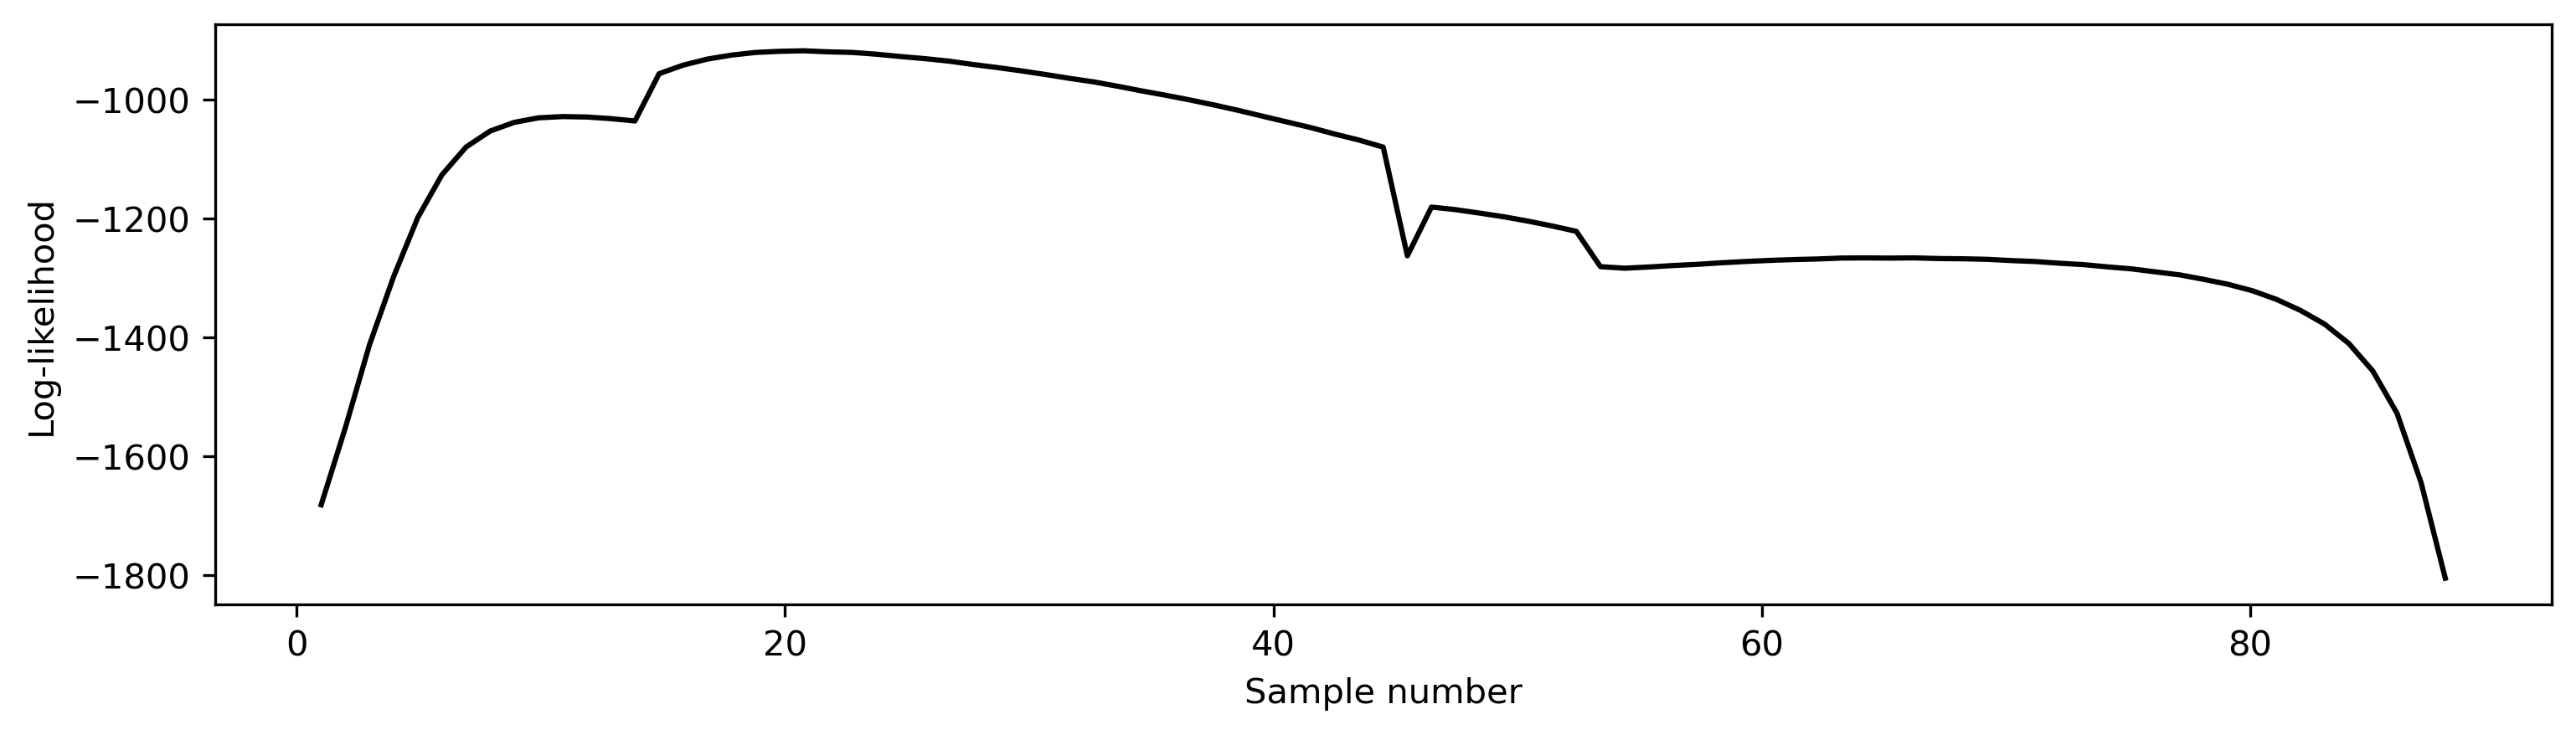

In [7]:
init.sliding_event(method=None)

# Discovering a event number through a cumulative approach

The ```fit``` function works on the same idea as the sliding event where a model is fit with starting points to the stage duration from 0 to mean RT. When an event differers significantly from the previous one (```threshold``` argument) one event is added to the model and the slide continues. This way we can detect events while accounting for the previous ones. 

In [8]:
%%time
estimates = init.fit(step=1, threshold=1)

  0%|          | 0/89 [00:00<?, ?it/s]

Transition event 2 found around sample 27
Transition event 3 found around sample 44
Transition event 4 found around sample 72
Estimating 4 events model
Parameters estimated for 4 events model
CPU times: user 51.4 s, sys: 1.63 ms, total: 51.4 s
Wall time: 51.4 s


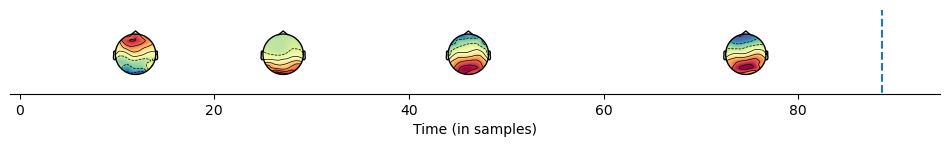

In [9]:
hmp.visu.plot_topo_timecourse(eeg_data, estimates, positions, init, times_to_display=np.mean(init.ends - init.starts))

With large dataset computation time might be very long, in this case you can use the step argument to skip some points between 0 and mean RT

In [10]:
%%time
estimates = init.fit(step=4, threshold=1)

  0%|          | 0/88 [00:00<?, ?it/s]

Transition event 2 found around sample 27
Transition event 3 found around sample 44
Transition event 4 found around sample 72
Estimating 4 events model
Parameters estimated for 4 events model
CPU times: user 8.14 s, sys: 91.2 ms, total: 8.23 s
Wall time: 8.13 s


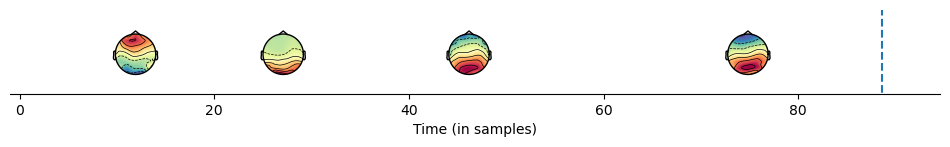

In [11]:
hmp.visu.plot_topo_timecourse(eeg_data, estimates, positions, init, times_to_display=np.mean(init.ends - init.starts))

In this example we evaluated the likelihood of (cumulatively) placing a event every 4 sample. This resulted in a big speed up, the benefit can be dramatic for large dataset. Keep in mind though that skipping too much samples might overly distord the event detection. Always check against the function fitted on more points (i.e. smaller steps).

We can also inspect the traces of the algorithm, if we provide the argument for it before the fit. This way we store both the proposed stage durations and the accepted events.

In [12]:
estimates, traces = init.fit(step=1, threshold=1, trace=True, verbose=False)

  0%|          | 0/89 [00:00<?, ?it/s]

Calling the ```plot_iterations``` of the visualization module then plots the proposed events in the algorithm at each iteration. In the case of the last cell, the "time course" of the algorithm is the following:

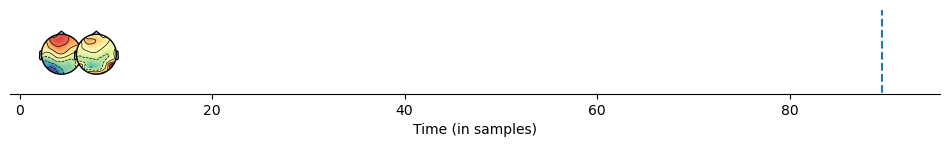

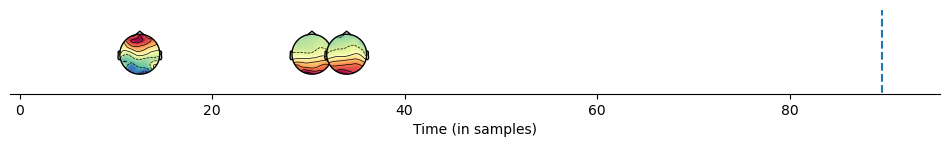

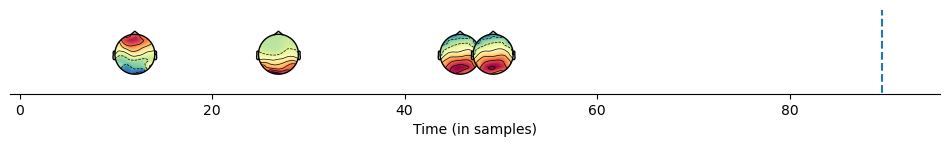

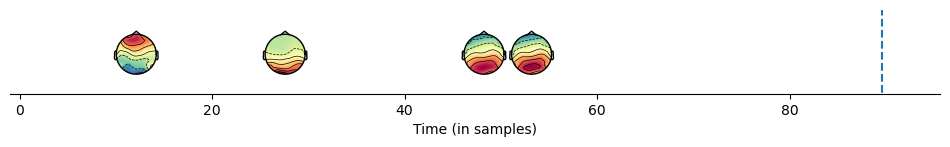

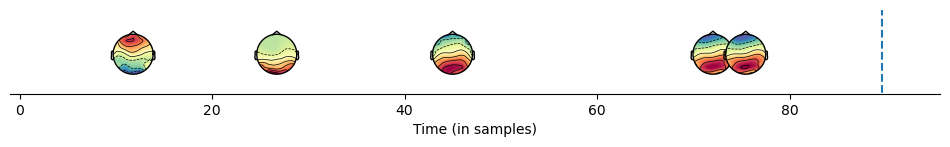

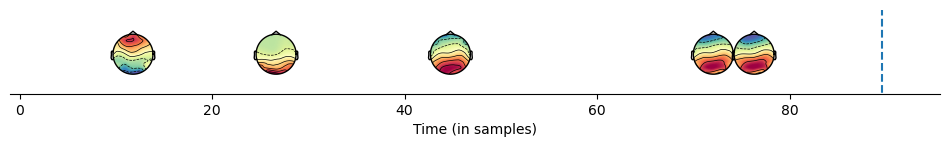

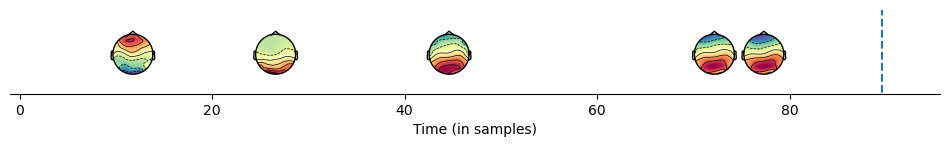

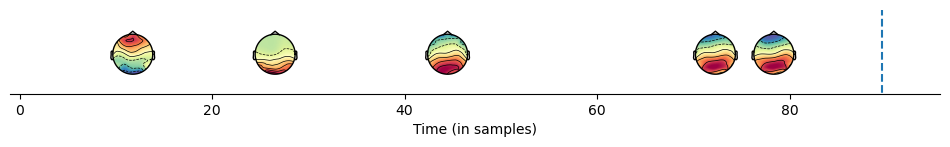

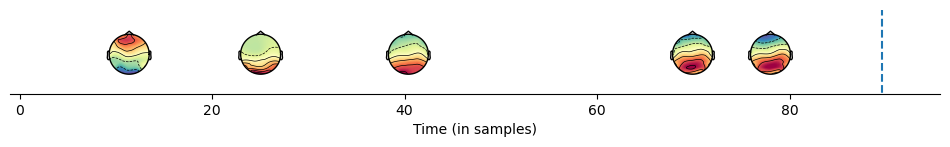

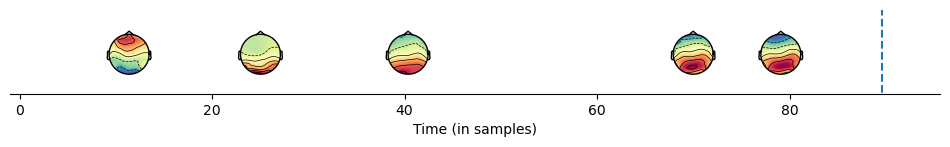

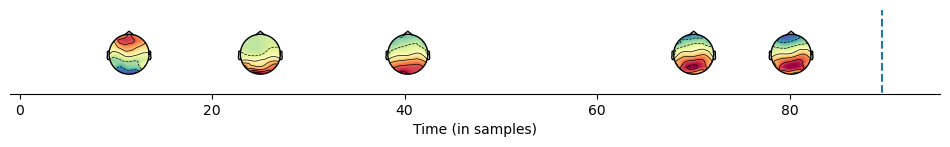

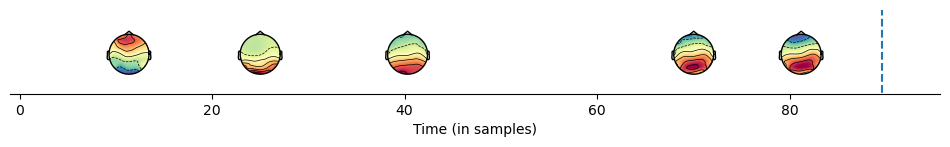

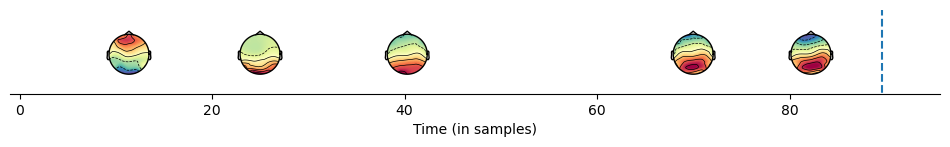

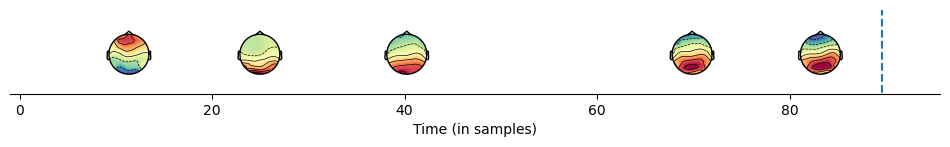

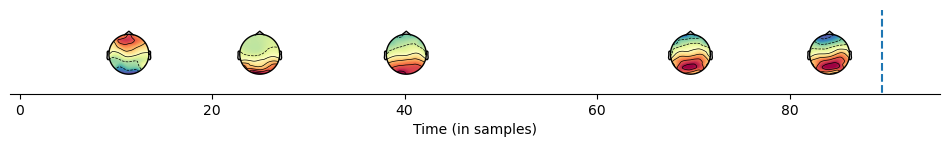

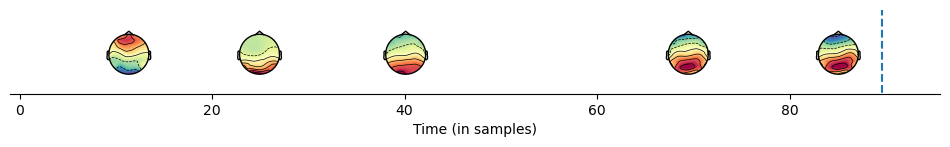

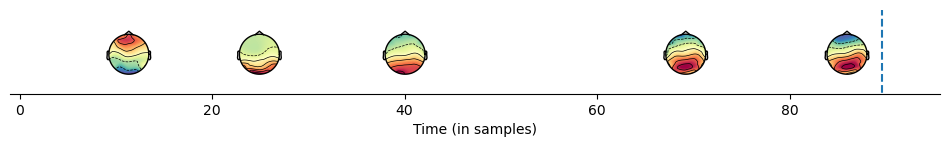

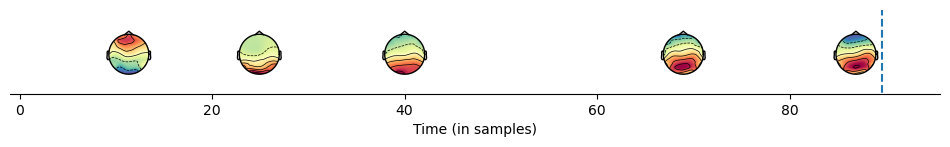

In [13]:
hmp.visu.plot_iterations(traces, eeg_data, init, positions, ['magnitudes_proposed','parameters_proposed'])

This is also how you might see whether some events might have been overlooked. Now EEG data is noisy and you might find more or less events with a given threshold. A way to assess this variation is to use the bootstrapping method.

### Illustration of the principle of bootstrapping

In the case of EEG data for a group or even a single participant we can bootstrap the epochs or trials of the EEG. The idea is that 1) generating a bootstraped dataset, 2) fitting a model using the cumulative approach and 3) recording the parameters of the HMP model. We expect that with enough bootstrapped sampels we will know wich events tend to be rare (e.g. strategies) and what is the variance in time and electrode contribution.

In [14]:
import xskillscore as xs #Just needed for the illustration
bootstapped = xs.resample_iterations(hmp_data.unstack(), iterations=1, dim='epochs')
hmp_data_boot = hmp.utils.stack_data(bootstapped.squeeze())
init_boot = hmp.models.hmp(hmp_data_boot, sfreq=eeg_data.sfreq, event_width=50, cpus=15)
estimates_boot = init_boot.fit(threshold = 1)

  0%|          | 0/93 [00:00<?, ?it/s]

Transition event 2 found around sample 27
Transition event 3 found around sample 42
Transition event 4 found around sample 74
Transition event 5 found around sample 84
Estimating 5 events model
Parameters estimated for 5 events model


Next we compare to the times that we estimated on the initial run:

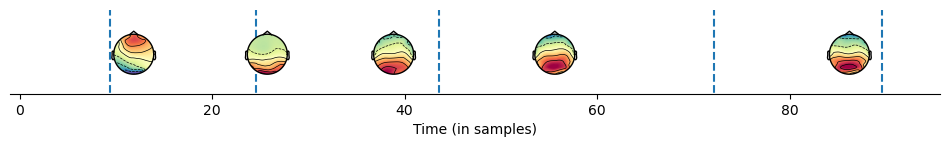

In [15]:
times_general_run = init.compute_times(init, estimates, duration=False, mean=True, add_rt=True)
hmp.visu.plot_topo_timecourse(eeg_data, estimates_boot, positions, init, 
                               times_to_display=times_general_run.values)

Of course this is automated in the HMP package, here an example for 10 iterations.

In [16]:
booted = hmp.utils.bootstrapping(init, hmp_data, estimates, positions, eeg_data, iterations=10, threshold=1, cpus=cpus, plots=False, verbose=False)

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

We can then plot the bootstrapped models (or leave the plots argument as True when calling the previous function).

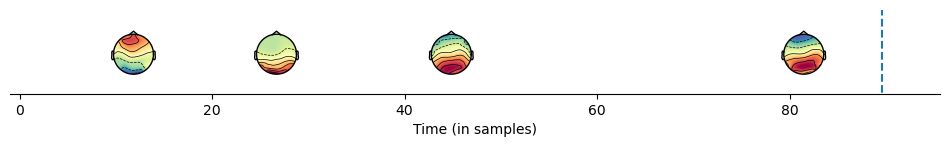

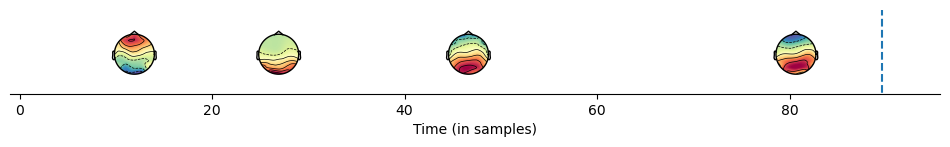

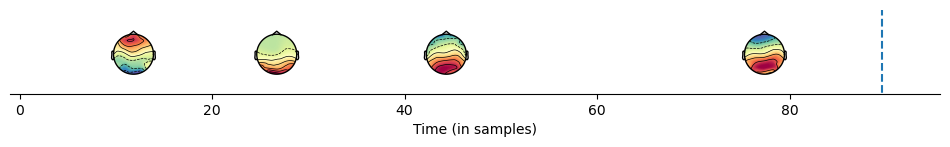

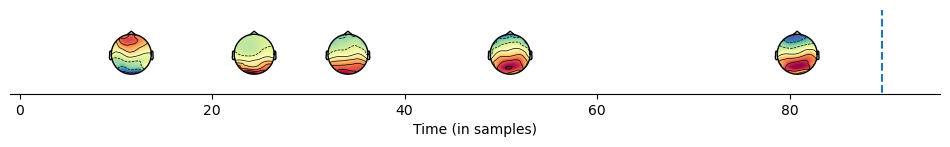

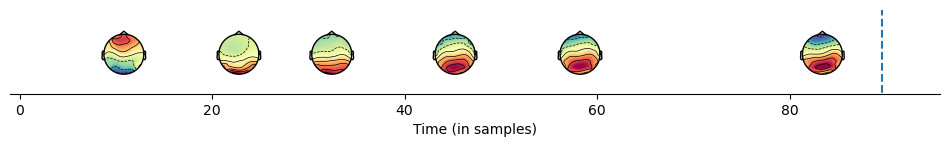

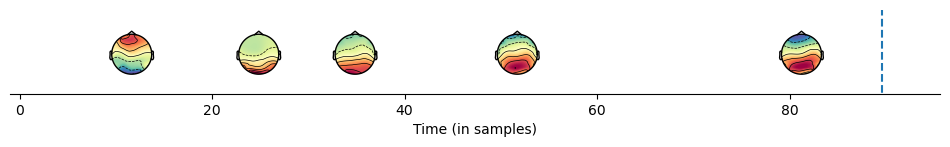

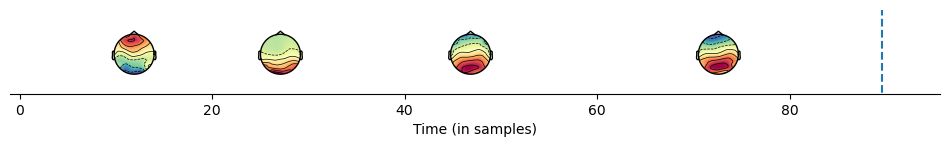

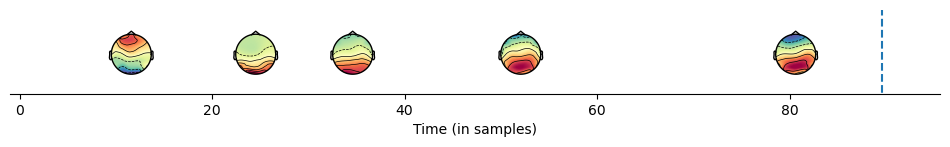

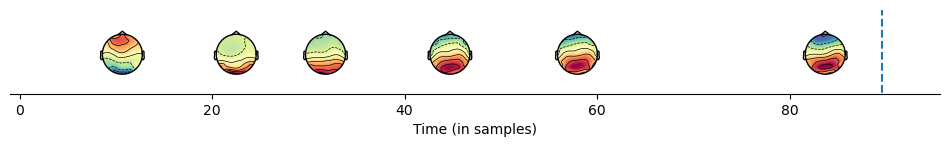

In [17]:
hmp.visu.plot_iterations(booted, eeg_data, init, positions, ['magnitudes','parameters'])

We can then use these bootstrapped data to 1) assess variability in event detection for a given threshold and 2) the variation in the location of the events and electrode contribution for a given _n_ event model

## Fitting from the maximum number of event to a 1 event model

An alternative way of assessing the number of events is to use the ```backward_estimation``` as discussed in the previous tutorial

Estimating 8 events model with 1 starting point(s)
Parameters estimated for 8 events model


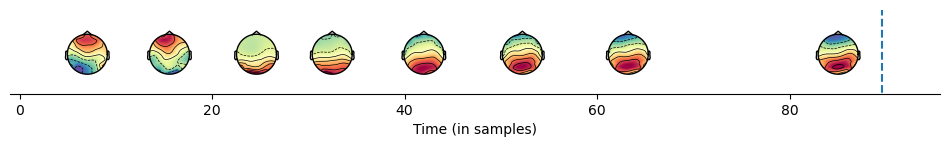

In [21]:
max_fit = init.fit_single()
hmp.visu.plot_topo_timecourse(eeg_data, max_fit, positions, init)

In [22]:
%%time 
bests = init.backward_estimation(max_fit=max_fit)#we can also leave the max_fit argument empty and it will be computed as above

Estimating all solutions for 7 number of events
Estimating all solutions for 6 number of events
Estimating all solutions for 5 number of events
Estimating all solutions for 4 number of events
Estimating all solutions for 3 number of events
Estimating all solutions for 2 number of events
Estimating all solutions for 1 number of events
CPU times: user 757 ms, sys: 1.65 s, total: 2.4 s
Wall time: 24.5 s


Here we plot the resulting solutions going from the maximal possible number of events that fit into the minimum RT given a duration of 50ms (default) in this example .

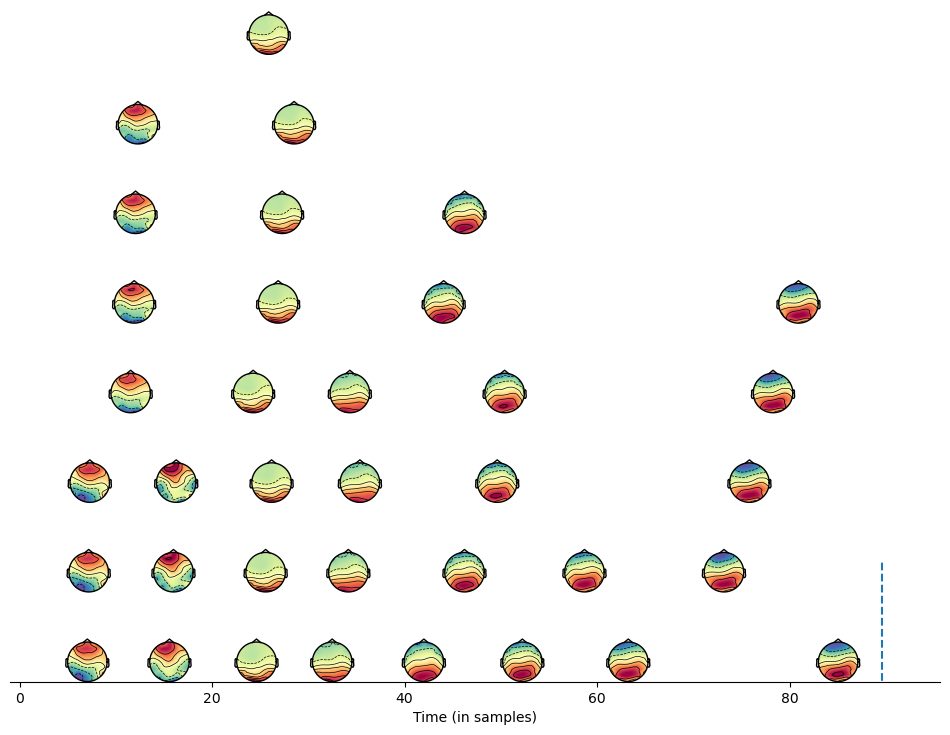

In [23]:
hmp.visu.plot_topo_timecourse(eeg_data, bests, positions, init, ydim='n_events')

But adding more and more parameters will almost always improve the fit (except when events start pushing each other because of the defined minimum duration). To illustrate this we can plot the raw likelihood

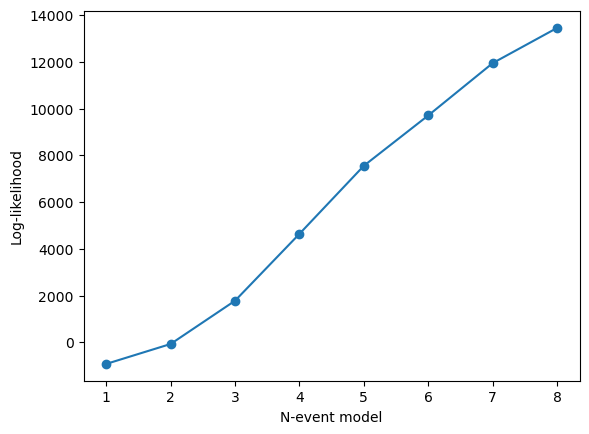

In [24]:
import matplotlib.pyplot as plt 

plt.plot(bests.n_events, bests.likelihoods,'o-')

plt.ylabel('Log-likelihood')
plt.xlabel('N-event model')
plt.show()

Hence we need a way to penalize the likelihood if the events location do not generalize to all participants. One way to do this is to perform a leave-one out cross-validation. This approach consists in fitting the model to all participants but one, and evaluate the likelihood of the left out participant given the estimated parameters without the participant. The function ```hmp.utils.loocv_mp``` does this and we can apply it to all participants and all *n* event model.

Note that the LOOCV can be very slow when there are a lot of participants, in this case it might be worth it to add multiprocessing through the cpus parameter

In [25]:
%%time
loocv = hmp.utils.loocv_mp(init, hmp_data, bests, cpus=4)#We set the cpus to 4 as there are 4 participants in the dataset

LOOCV for model with 8 event(s)
LOOCV for model with 7 event(s)
LOOCV for model with 6 event(s)
LOOCV for model with 5 event(s)
LOOCV for model with 4 event(s)
LOOCV for model with 3 event(s)
LOOCV for model with 2 event(s)
LOOCV for model with 1 event(s)
CPU times: user 286 ms, sys: 664 ms, total: 950 ms
Wall time: 4.52 s


We can then plot the result from the LOOCV procedure

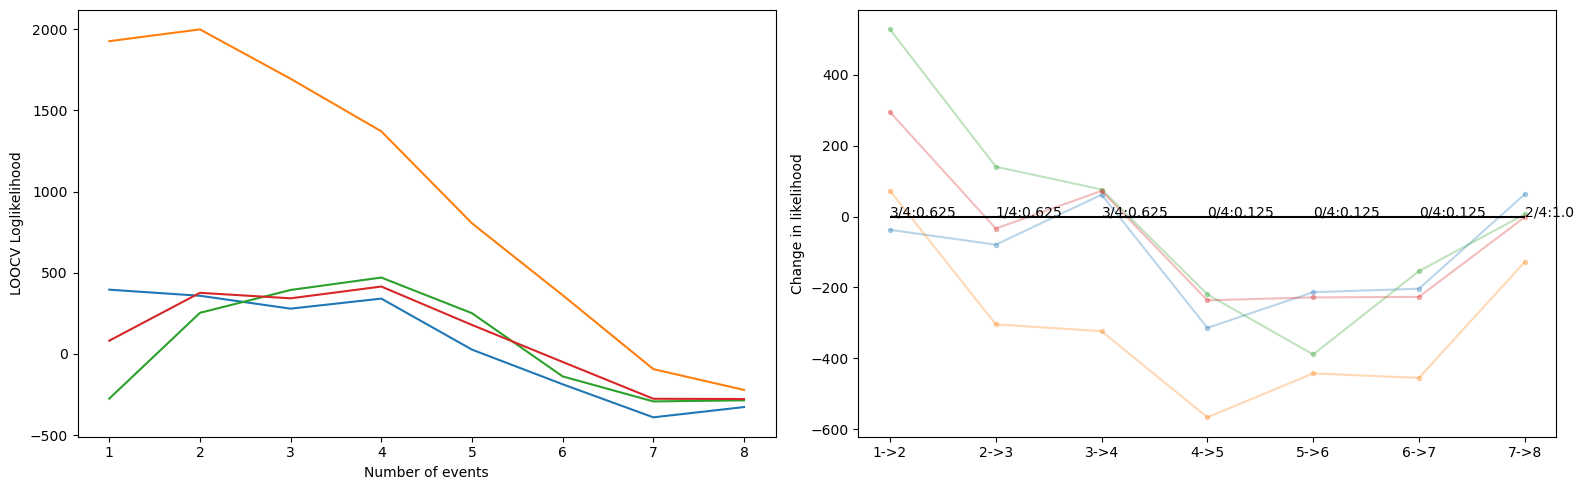

In [26]:
hmp.visu.plot_loocv(loocv, pvals=True, test='sign', indiv=True)#Colored shaded lines represent individuals

With 4 participants the results are obviously not to be taken too seriously. The figure contains the p-value for a sign test but it cannot be significant with 4 participants. In this case going from 1 to 2 events and from 3 to 4 are the best options (see right panel) according to the number of participant for which the likelihood increased (3/4). We can also see that on the overall LOOCV score (left panel) the 1 event model is poorer than the 4 event model for 2 participants, so we can just select this one:

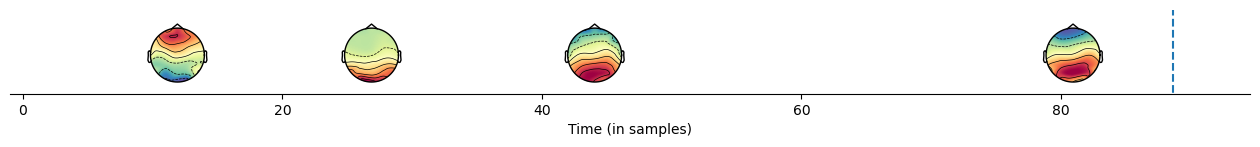

In [27]:
selected = bests.sel(n_events=4)

hmp.visu.plot_topo_timecourse(eeg_data, selected, positions, init,  figsize=(16,1),
                                time_step = 1,  times_to_display = np.mean(init.ends - init.starts))

And we can now inspect specific aspects of that fit, see the next tutorial